# Prepare data

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown -O data.zip --id 1wzpU0KPGbpmrYMYkAP2Z-Hk3WYk5-UBh
!7z x data.zip
!mv 100_Sports_Image_Classification data

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=d200c78a5478e0d3e48163aa099020b9dbe98d2ef3b6a0fc6fe43e27c0625f8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-evzli5fu/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.1
    Uninstalling gdown-4.2.1:
      Successfully uninstalled gdown-4.2.1
Downloading...
From: https://drive.google.com/uc?id=1wzpU0KPGbpmrYMYkAP2Z-Hk3WYk5-UBh
To: /content/data.zip
100% 365M/365M [00:02<00:00, 129MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 365433

# Import

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import tqdm
import pickle
import glob
import os
print("Torch version:", torch.__version__)

Torch version: 1.10.0+cu111


# Baseline model (AlexNet)

In [ ]:
def make_norm_layer(norm_type, in_channels=None, n_group=4):
    if norm_type == 'BN': return nn.BatchNorm2d(in_channels)
    if norm_type == 'LN': return nn.GroupNorm(1, in_channels) # Use GN to avoid define [C, W, H] in LN, pytorch suck!
    if norm_type == 'IN': return nn.InstanceNorm2d(in_channels)
    if norm_type == 'GN': return nn.GroupNorm(n_group, in_channels)
    if norm_type == 'LN+BN': return nn.Sequential(
        nn.GroupNorm(1, in_channels), nn.BatchNorm2d(in_channels)
    )
    return nn.Identity()

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 100, norm_type=None, dropout=None) -> None:
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            make_norm_layer(norm_type, 64),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            make_norm_layer(norm_type, 192),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            make_norm_layer(norm_type, 384),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            make_norm_layer(norm_type, 256),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            make_norm_layer(norm_type, 256),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout) if dropout is not None else nn.Identity(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout) if dropout is not None else nn.Identity(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet(100, norm_type=None)
torchsummary.summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
          Identity-4           [-1, 64, 27, 27]               0
            Conv2d-5          [-1, 192, 27, 27]         307,392
              ReLU-6          [-1, 192, 27, 27]               0
         MaxPool2d-7          [-1, 192, 13, 13]               0
          Identity-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         663,936
             ReLU-10          [-1, 384, 13, 13]               0
         Identity-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         884,992
             ReLU-13          [-1, 256, 13, 13]               0
         Identity-14          [-1, 256,

# Preprocessing

In [ ]:
preprocess = {
    "train-no-aug": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "train-aug": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224,224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid-no-aug": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "valid-aug": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Prepare Dataset & Dataloader

## Dataset without augmentation

In [ ]:
trainset = torchvision.datasets.ImageFolder(root="./data/train", transform=preprocess["train-no-aug"])
validset = torchvision.datasets.ImageFolder(root="./data/valid", transform=preprocess["valid-no-aug"])

## Dataset with augmentation

In [ ]:
trainset = torchvision.datasets.ImageFolder(root="./data/train", transform=preprocess["train-aug"])
validset = torchvision.datasets.ImageFolder(root="./data/valid", transform=preprocess["valid-aug"])

## Dataloader

In [ ]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(validset, batch_size=32, num_workers=2)

## Visualization

N classes: 100
Min: 59, Max: 191
Mean: 135.72, Std: 21.65782999286863


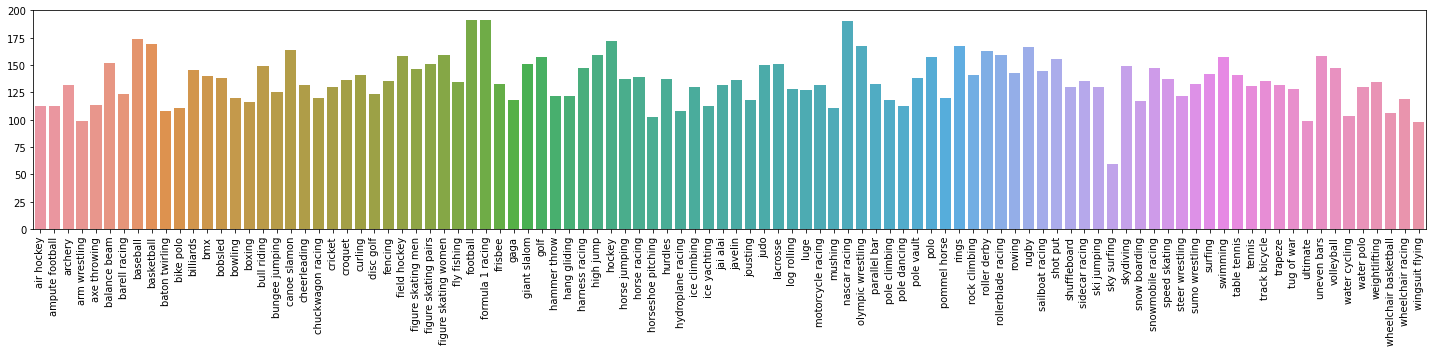

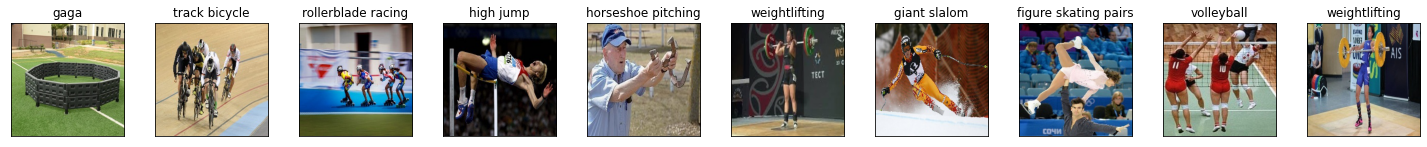

In [ ]:
from IPython.core.pylabtools import figsize

print("N classes:", len(trainset.classes))
count_label = [0] * len(trainset.classes)
for _, label_idx in trainset.samples: count_label[label_idx] += 1
count_label = np.array(count_label)
print(f"Min: {count_label.min()}, Max: {count_label.max()}")
print(f"Mean: {count_label.mean()}, Std: {count_label.std()}")

plt.figure(figsize=(20,5))
sns.barplot(x=trainset.classes, y=count_label)
plt.xticks(rotation=90)
plt.tight_layout()

fig, axes = plt.subplots(1, 10, figsize=(20,2), subplot_kw={"xticks": [], "yticks": []})
for i, ax in enumerate(axes.flat):
    j = random.randint(0, len(trainset) - 1)
    img, label = trainset[j]
    ax.imshow(np.asarray(transforms.ToPILImage()(img)))
    ax.set_title(trainset.classes[label])

plt.tight_layout()

# Training

## Train loop

In [ ]:
def train_loop(model, loss_fn, optimizer, dataloader):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, labels in tqdm.notebook.tqdm(dataloader):
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        true_pred = (labels == torch.argmax(outputs, dim=1)).sum().item()
        epoch_acc += true_pred

    total_sample = len(dataloader.dataset)
    return epoch_loss/total_sample, epoch_acc/total_sample

## Valid loop

In [ ]:
def valid_loop(model, loss_fn, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_acc = 0
        for inputs, labels in dataloader:
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            true_pred = (labels == torch.argmax(outputs, dim=1)).sum().item()
            val_loss += loss.item() * inputs.size(0)
            val_acc += true_pred

        total_sample = len(dataloader.dataset)
        return val_loss/total_sample, val_acc/total_sample


## Train model

In [ ]:
all_history = {}
!mkdir save

In [ ]:
# model = AlexNet(len(trainset.classes), norm_type=None)
# model = AlexNet(len(trainset.classes), norm_type='BN')
# model = AlexNet(len(trainset.classes), norm_type='LN')
# model = AlexNet(len(trainset.classes), norm_type='IN')
# model = AlexNet(len(trainset.classes), norm_type='GN')
# model = AlexNet(len(trainset.classes), norm_type='LN+BN')
# model = AlexNet(len(trainset.classes), norm_type=None, dropout=0.5)
# model = AlexNet(len(trainset.classes), norm_type='BN', dropout=0.5)

# Pretrain model, freezing all layers except the last custom layer
model = torchvision.models.alexnet(pretrained=True, progress=True)
for param in model.parameters(): param.requires_grad = False
in_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_ftrs, len(trainset.classes))

model.to("cuda")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[-1].parameters(), lr=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
history = []

In [ ]:
for param in model.parameters(): param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):
    print(f"Epoch {epoch} ====================================================")
    train_loss, train_acc = train_loop(model, loss_fn, optimizer, trainloader)
    val_loss, val_acc = valid_loop(model, loss_fn, valloader)
    
    hist = [train_loss, val_loss, train_acc, val_acc]
    print(f"Loss: train {train_loss:.3}, val {val_loss:.3} - Acc: train {train_acc:.3}, val {val_acc:.3}")
    history.append(hist)

Epoch 0 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.138, val 0.893 - Acc: train 0.954, val 0.808
Epoch 1 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.142, val 0.683 - Acc: train 0.956, val 0.838
Epoch 2 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.138, val 0.742 - Acc: train 0.959, val 0.814
Epoch 3 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.129, val 0.568 - Acc: train 0.959, val 0.858
Epoch 4 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.129, val 0.613 - Acc: train 0.959, val 0.858
Epoch 5 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.116, val 0.714 - Acc: train 0.965, val 0.826
Epoch 6 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.119, val 0.663 - Acc: train 0.963, val 0.848
Epoch 7 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.13, val 0.687 - Acc: train 0.962, val 0.85
Epoch 8 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.124, val 0.901 - Acc: train 0.961, val 0.79
Epoch 9 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.104, val 0.806 - Acc: train 0.969, val 0.806
Epoch 10 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.126, val 0.804 - Acc: train 0.959, val 0.814
Epoch 11 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.0982, val 0.947 - Acc: train 0.97, val 0.828
Epoch 12 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

Loss: train 0.105, val 0.954 - Acc: train 0.968, val 0.812
Epoch 13 ====================================================


  0%|          | 0/425 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def draw_plot_and_save(history, name):
    global all_history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    history = np.array(history)
    print("train loss, val loss, train acc, val acc")
    print(history[-5:], '\n')
    n_epoch = history.shape[0]
    ax1.plot(range(n_epoch), history[:, 0], label='train loss')
    ax1.plot(range(n_epoch), history[:, 1], label='val loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(range(n_epoch), history[:, 2], label='train acc')
    ax2.plot(range(n_epoch), history[:, 3], label='val acc')
    ax2.legend()
    ax2.grid(True)

    all_history[name] = history
    with open('./save/all_history', 'wb') as f:
        pickle.dump(all_history, f)
    with open(f'./save/{name}', 'wb') as f:
        pickle.dump(history, f)


# Results

## Result Baseline model

Epoch, train loss, val loss, train acc, val acc
[[0.04731257 3.99344397 0.98577955 0.49      ]
 [0.03277221 3.9602137  0.98968464 0.5       ]
 [0.02410893 3.69311233 0.99322134 0.508     ]
 [0.05656885 3.78584519 0.98356911 0.504     ]
 [0.0279065  3.94902501 0.99160035 0.528     ]] 



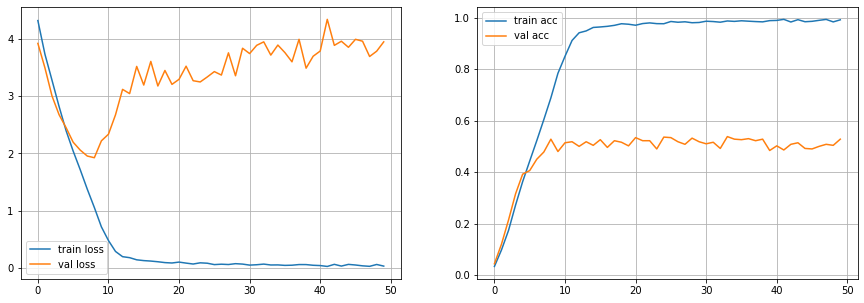

In [ ]:
draw_plot_and_save(history, 'baseline')

## Result Baseline + BN

train loss, val loss, train acc, val acc
[[0.02260698 2.52541084 0.99351606 0.626     ]
 [0.01819441 2.52888376 0.99381079 0.632     ]
 [0.00475039 2.36145157 0.99852638 0.646     ]
 [0.00870503 2.60884311 0.99756852 0.612     ]
 [0.06129562 2.80805663 0.98349543 0.59      ]] 



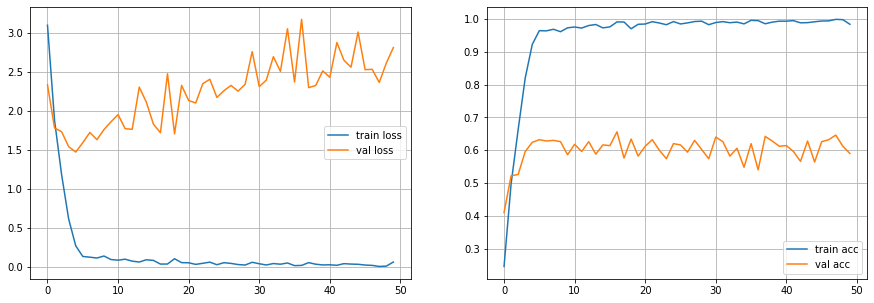

In [ ]:
draw_plot_and_save(history, 'bn')

## Result Baseline + Layer Norm

train loss, val loss, train acc, val acc
[[0.0514819  3.3518337  0.98482169 0.534     ]
 [0.02896442 3.10377779 0.99160035 0.5       ]
 [0.01668267 3.43494011 0.994916   0.516     ]
 [0.01676782 3.40784172 0.99528441 0.544     ]
 [0.01141722 3.58690749 0.99557913 0.51      ]] 



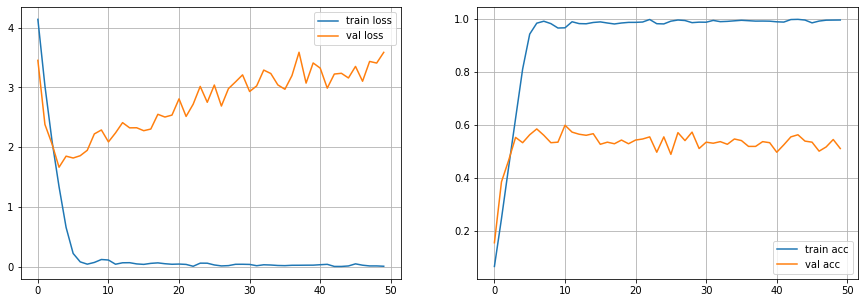

In [ ]:
draw_plot_and_save(history, 'ln')

## Result Baseline + Instance Norm

train loss, val loss, train acc, val acc
[[0.01413164 4.17049094 0.994916   0.474     ]
 [0.02655855 4.02500343 0.9918214  0.48      ]
 [0.04983763 4.27907478 0.98585323 0.444     ]
 [0.02081947 4.14487721 0.99440024 0.47      ]
 [0.00935296 3.78856237 0.99683171 0.494     ]] 



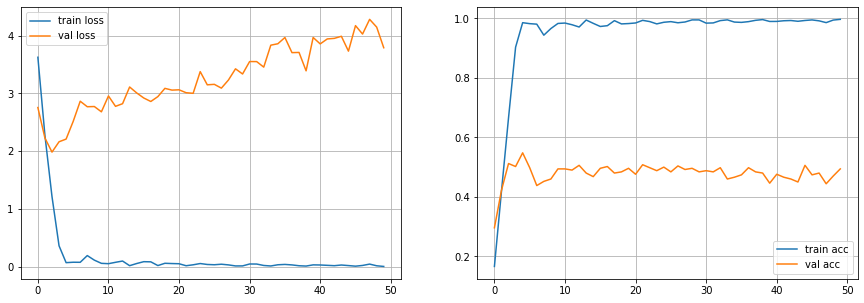

In [ ]:
draw_plot_and_save(history, 'in')

## Result Baseline + Group Norm

train loss, val loss, train acc, val acc
[[0.04002278 3.3275645  0.98813734 0.53      ]
 [0.03356723 3.21086902 0.98880047 0.542     ]
 [0.01417057 3.16012248 0.99646331 0.554     ]
 [0.04176116 2.96857445 0.98747421 0.562     ]
 [0.01571887 3.03932936 0.99476864 0.562     ]] 



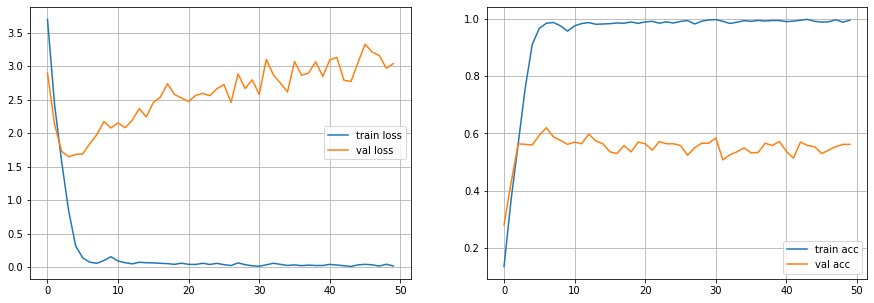

In [ ]:
draw_plot_and_save(history, 'gn')

## Result Baseline + LN + BN

train loss, val loss, train acc, val acc
[[0.01756466 2.79969743 0.99521073 0.606     ]
 [0.00961575 2.67909611 0.99675803 0.608     ]
 [0.01741933 3.33969469 0.99425287 0.542     ]
 [0.04182589 2.67232801 0.98843207 0.624     ]
 [0.02143543 2.95842901 0.99292661 0.604     ]] 



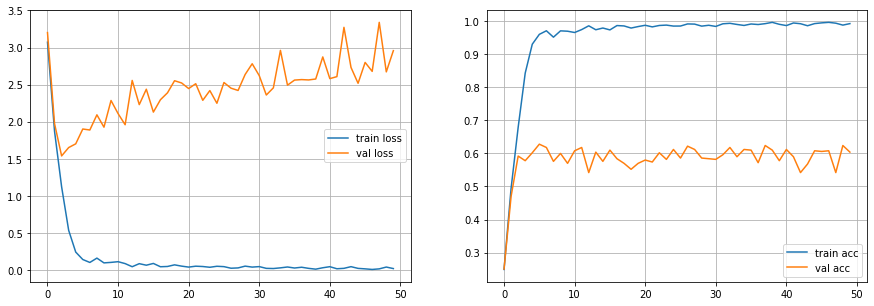

In [ ]:
draw_plot_and_save(history, 'ln-bn')

## Result Baseline + Dropout

train loss, val loss, train acc, val acc
[[0.09067228 2.42885867 0.97089596 0.592     ]
 [0.08719101 2.37937985 0.97325376 0.572     ]
 [0.07476619 2.61324943 0.97656941 0.566     ]
 [0.08755695 2.34426296 0.97273799 0.594     ]
 [0.07615147 2.30341558 0.97575892 0.594     ]] 



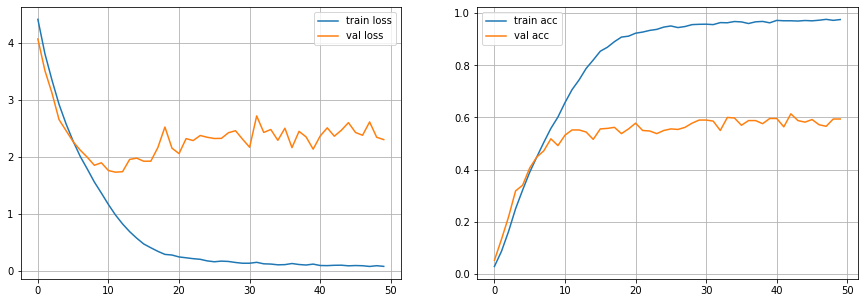

In [ ]:
draw_plot_and_save(history, 'dropout')

## Result Baseline + Dropout + BN

train loss, val loss, train acc, val acc
[[0.05146707 1.99014766 0.98629531 0.682     ]
 [0.03702828 1.97894208 0.98857943 0.678     ]
 [0.03224038 2.09421271 0.98938992 0.656     ]
 [0.03960396 2.34546369 0.98902151 0.658     ]
 [0.04413044 2.13603993 0.98703212 0.656     ]] 



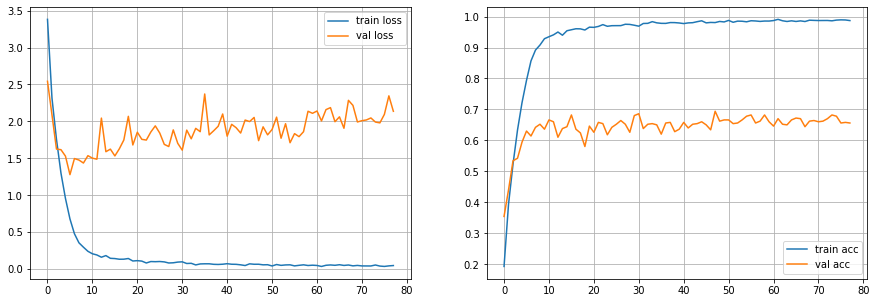

In [ ]:
draw_plot_and_save(history, 'dropout-bn')

## Result Baseline + Weight decay L2 (0.0001)

train loss, val loss, train acc, val acc
[[0.06879226 3.59559748 0.98054819 0.526     ]
 [0.03041897 3.29640656 0.99196876 0.534     ]
 [0.06358769 3.71861557 0.98172709 0.502     ]
 [0.03532177 3.45040635 0.98968464 0.5       ]
 [0.04388359 3.44890768 0.98717949 0.508     ]] 



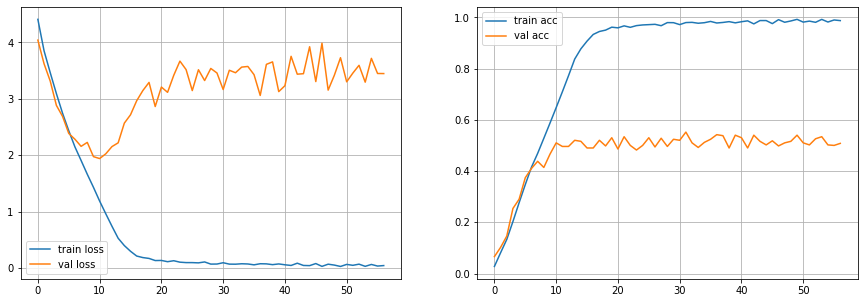

In [ ]:
draw_plot_and_save(history, 'weight-decay')

## Result Baseline + Augmentation

train loss, val loss, train acc, val acc
[[0.12362196 2.92222874 0.96013852 0.56      ]
 [0.14187493 2.81251562 0.95623342 0.566     ]
 [0.11678675 2.45995185 0.96433834 0.588     ]
 [0.13332753 2.82076162 0.96065429 0.57      ]
 [0.10538032 2.98314774 0.9680224  0.566     ]] 



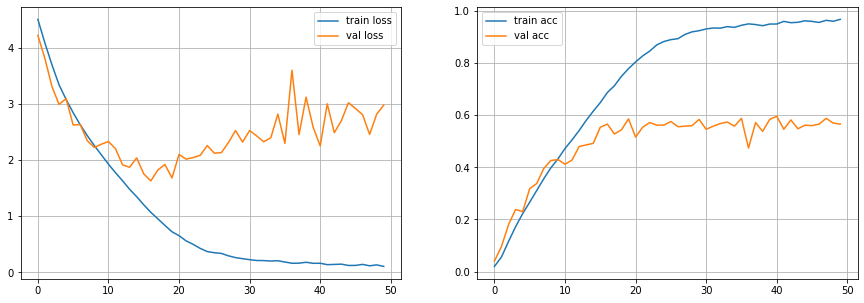

In [ ]:
draw_plot_and_save(history, 'augmentation')

## Result Baseline + BN + Dropout + Augmentation (Ultra ultimate Alexnet)

train loss, val loss, train acc, val acc
[[0.16960295 1.25168218 0.94783378 0.752     ]
 [0.13686511 1.24691704 0.95527557 0.724     ]
 [0.15106151 1.34993065 0.95151783 0.746     ]
 [0.1536652  1.35589139 0.95019157 0.71      ]
 [0.1349708  1.32467271 0.9563071  0.722     ]] 



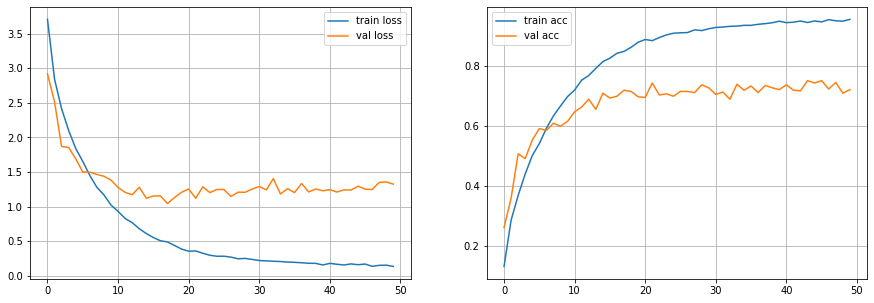

In [ ]:
draw_plot_and_save(history, 'ultimate')

train loss, val loss, train acc, val acc
[[0.1242393  0.90055059 0.96058061 0.79      ]
 [0.10361009 0.80551594 0.96934866 0.806     ]
 [0.12628469 0.80385637 0.95918067 0.814     ]
 [0.0981896  0.94734367 0.96993811 0.828     ]
 [0.10539531 0.95432461 0.96758031 0.812     ]] 



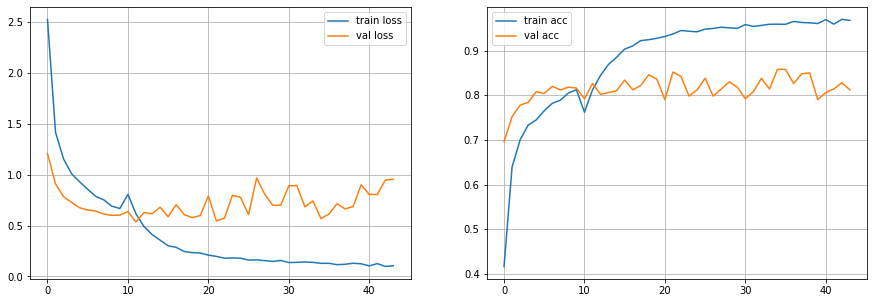

In [ ]:
draw_plot_and_save(history, 'pretrain')

# Combine all results

## Prepare
*Note: ULTIMATE = BN + Dropout + Augmentation*

In [ ]:
files = glob.glob("./save/*")
n_epoch = 50

names = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for f in files:
    with open(f, "rb") as fi:
        hist = pickle.load(fi)
        names.append(os.path.basename(f).upper())
        train_losses.append(hist[:n_epoch, 0])
        val_losses.append(hist[:n_epoch, 1])
        train_accs.append(hist[:n_epoch, 2])
        val_accs.append(hist[:n_epoch, 3])

def draw_chart(data, names):
    plt.figure(figsize=(10,7))
    styles = ['-', '--', ':']
    for i, name in enumerate(names):
        plt.plot(range(50), data[i], label=name, linestyle=styles[i % len(styles)])

    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


## Train loss

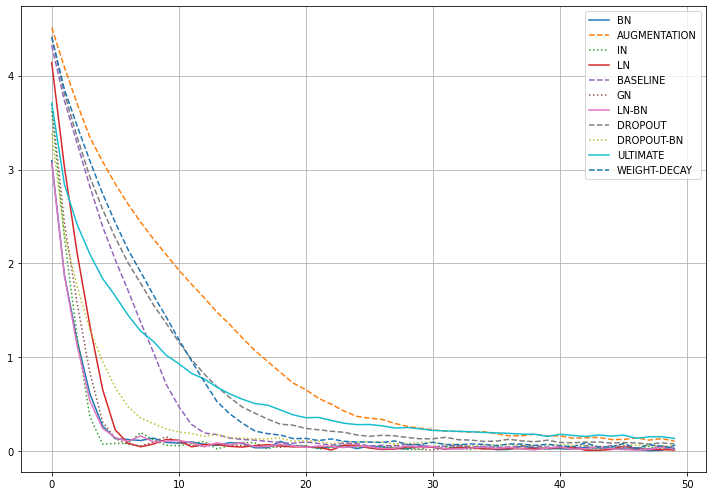

In [ ]:
draw_chart(train_losses, names)

## Val loss

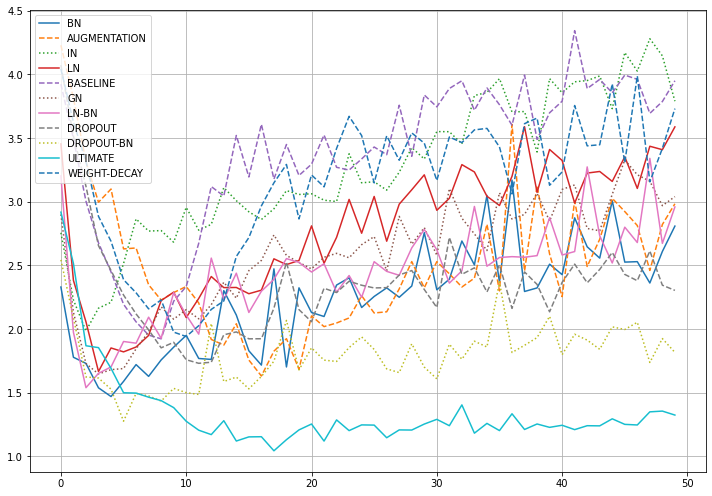

In [ ]:
draw_chart(val_losses, names)

## Train Accuracy

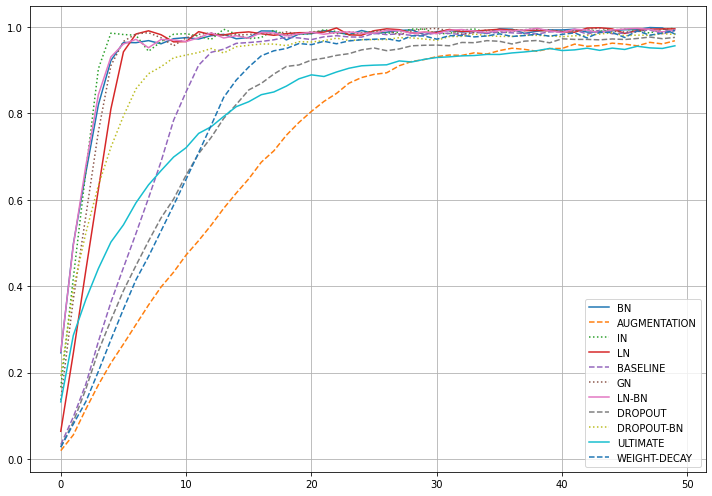

In [ ]:
draw_chart(train_accs, names)

## Val Accuracy

Ultimate = BN + Dropout + Augmentation

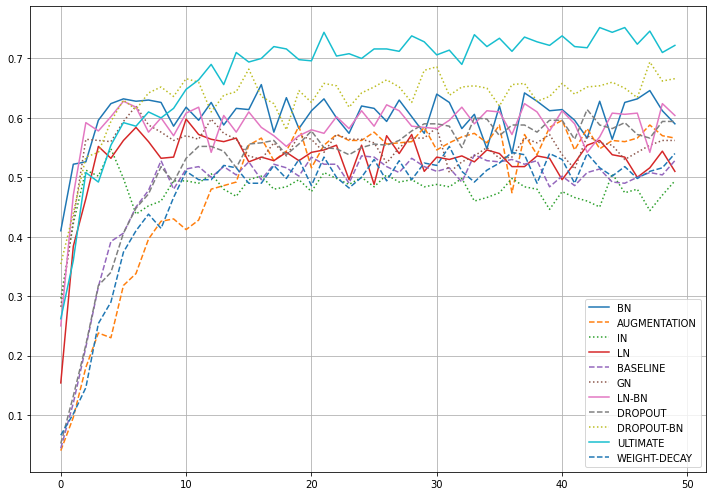

In [ ]:
draw_chart(val_accs, names)